In [1]:
import psycopg2
import psycopg2.extras

class Db(object):
    _connection = None
    
    def __init__(self, host="localhost", user="user", password="1", db="db"):
        try:
            self._connection = psycopg2.connect("host='{0}' user='{1}' password='{2}' dbname='{3}'".format(
                    host, user, password, db))
        except psycopg2.Error as err:
            print("Connection error: {}".format(err))
            self._connection.close()
    
    def query(self, sql, params=None, cursor='list'):
        if not self._connection:
            return False
        
        data = False
        
        if cursor == 'dict':
            # Assoc cursor
            factory = psycopg2.extras.DictCursor
        else:
            # Standard cursor
            factory = psycopg2.extensions.cursor
        try:
            cur = self._connection.cursor(cursor_factory=factory) # by column name
            cur.execute(sql, params)
            data = cur.fetchall()
        except psycopg2.Error as err:
            print("Query error: {}".format(err))
            
        return data

db = Db(host="localhost", user="developer", password="1", db="go_finance")

In [3]:
import operator
import matplotlib.pyplot as plt
import numpy as np
import talib
from datetime import date, timedelta
table = 'prices'
order_dt = 'ASC'

def prices(symbols, dt_from = date.today(), period = 90):
    """
    Get prices from database for one or multiple symbols.
    """
    dt_to = dt_from - timedelta(days=period)
    cond = {
        'symbols': symbols,
        'to': dt_from,
        'from': dt_to
    }

    # FIXME Change to view
    sql = """
        SELECT
            symbol,
            dt,
            ROUND(CASE WHEN adj IS NOT NULL AND close > 0
                THEN adj / close::real ELSE 1 END * open) / {0} as open,
            ROUND(CASE WHEN adj IS NOT NULL AND close > 0
                THEN adj / close::real ELSE 1 END * high) / {0} as high,
            ROUND(CASE WHEN adj IS NOT NULL AND close > 0
                THEN adj / close::real ELSE 1 END * low) / {0} as low,
            CASE WHEN adj IS NOT NULL THEN adj ELSE close
                END::real / {0} as close,
            volume::int
        FROM {1}
        WHERE symbol IN (SELECT unnest(%(symbols)s)) AND dt BETWEEN %(from)s AND %(to)s
        ORDER BY dt {2}""".format(10000, table, order_dt)

    return db.query(sql, cond)

def check_stamp(symbols, stamp, length=30, corr=0.9):
    """
    Get prices for list of symbols and get correlation
    for every prices history.
    Leave in result only more correlated symbols.
    """
    to_check = prices(symbols, date.today(), 200)
    
    stamp_change = (stamp[1:] - stamp[:-1])
    stamp_change_prc = stamp_change / stamp[:-1]

    to_check_price = dict()
    corr_price = {s:0 for s in symbols}
    
    for symbol in symbols:
        to_check_price[symbol] = np.array([x[5] for x in to_check if x[0] == symbol])    
        if to_check_price[symbol].shape[0] < length:
            print("Symbol {0} does not have enough history ({1}).".format(symbol, to_check_price[symbol].shape[0]))
            continue
        corr_price[symbol] = talib.CORREL(stamp[-length:], to_check_price[symbol][-length:], length)[-1]

    sorted_price = sorted(corr_price.items(), key=operator.itemgetter(1))
    # filter by correlation
    sorted_price = ([r for r in sorted_price if r[1] >= corr] if corr > 0 
                    else [r for r in sorted_price if r[1] <= corr])
    return sorted_price


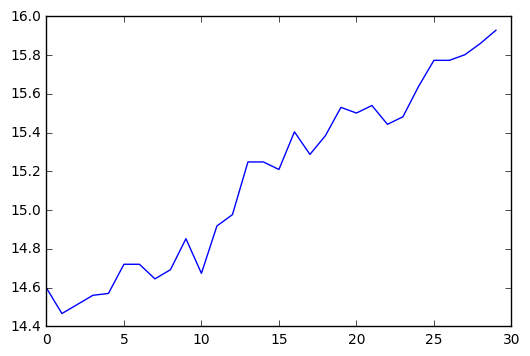

In [4]:
# stamp by price history
stamp = prices(['CIM'], date(2016, 7, 25), 200) # length=30, corr=0.93, long
# stamp = prices(['WIN'], date(2016, 9, 5), 200) # length=20, 0.90, long # inverted parabola
stamp = np.array([x[5] for x in stamp])

# stamp by function
# stamp = np.array([x/2 for x in range(0, 100, 1)], dtype=float) # length=30, corr=0.95, long # trend
# stamp = np.array([pow(1.05, i) for i in range(100)], dtype=float) # length=30, corr=0.95, long # growth trend
# stamp = np.array([x*x for x in range(-10, 11, 1)], dtype=float) # length=20, corr=0.90, long # inverted parabola

length, corr = 30, 0.93
stamp

# draw chart
plt.plot(stamp[-length:])
plt.show()

In [53]:
# get active symbols
sql = "SELECT symbol FROM listed WHERE is_listed AND price > 1 AND avg_volume > 500000 ORDER BY symbol"
r = db.query(sql)
listed_symbols = [s[0] for s in r]

# listed_symbols = ['NVDA', 'SLV', 'MMM', 'SPY', 'DIA', 'QQQ', 'GLD', 'UUP']
                             
corr = check_stamp(listed_symbols, stamp, length, corr)
corr, ",".join([s[0] for s in corr])

([('CLCD', 0.93012148710578646),
  ('IGT', 0.93100910550611993),
  ('MSGN', 0.9315266224715999),
  ('CC', 0.93172683478946694),
  ('WDC', 0.93192539032189403),
  ('ARNA', 0.93421969960973039),
  ('DEPO', 0.9355777010436267),
  ('GDDY', 0.93814287447947542),
  ('WR', 0.93896144710393381),
  ('ARIA', 0.93964676035938866),
  ('CTB', 0.940446619915003),
  ('IRWD', 0.94156098718246051),
  ('AERI', 0.94385893099306883),
  ('AGEN', 0.94507048115873193),
  ('SCYX', 0.9453570653194846),
  ('EXTR', 0.94656679262413745),
  ('CRIS', 0.94698861629309783),
  ('CSX', 0.94707983408987451),
  ('DISH', 0.94763055534725715),
  ('ETFC', 0.94786814265020458),
  ('SEM', 0.94915959536159356),
  ('ATRS', 0.95272958995438106),
  ('ILMN', 0.95332553817900367),
  ('BV', 0.95529156545673932),
  ('PTCT', 0.95667250693661721),
  ('KERX', 0.95957221564088169),
  ('CARA', 0.9623116668031052),
  ('LITE', 0.97099969979751632)],
 'CLCD,IGT,MSGN,CC,WDC,ARNA,DEPO,GDDY,WR,ARIA,CTB,IRWD,AERI,AGEN,SCYX,EXTR,CRIS,CSX,DISH,ETF

In [47]:
import numpy as np
import talib

arr = np.array([x for x in range(0, 100, 1)], dtype=float)
length = 50 # length of data for get correlation
corr = talib.CORREL(arr[-length:], arr[-length:], length)
print(corr[-1])

1.0


In [48]:
# SciPy & Numpy
import numpy as np
from scipy.stats import pearsonr

arr = np.array([x for x in range(0, 100, 1)], dtype=float)
length = 50 # length of data for get correlation
corr_np = np.corrcoef(arr[-length:], arr[-length:])
corr_scipy = pearsonr(arr[-length:], arr[-length:])
print(corr_np, corr_scipy)

[[ 1.  1.]
 [ 1.  1.]] (1.0, 0.0)


In [49]:
%timeit talib.CORREL(arr[-length:], arr[-length:], length)
%timeit np.corrcoef(arr[-length:], arr[-length:])
%timeit pearsonr(arr[-length:], arr[-length:])

The slowest run took 13.02 times longer than the fastest. This could mean that an intermediate result is being cached.
1000000 loops, best of 3: 1.03 µs per loop
10000 loops, best of 3: 82.2 µs per loop
10000 loops, best of 3: 54 µs per loop
